

---


## **Monitored Data**



---




## **1. Data 불러오기**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
# '/content/gdrive/My Drive/Colab Notebooks/pi_digits.txt'
with open('/content/gdrive/My Drive/Colab Notebooks/mon_standard.pkl', 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000

Mounted at /content/gdrive
Loading datafile...
Total samples: 19000


In [ ]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

## **2. feature 추출**

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들었습니다
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})


In [ ]:
df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


In [ ]:
! free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi        10Gi       158Mi       1.0Mi       2.4Gi       2.3Gi
Swap:             0B          0B          0B


## **3. Train RandomForest Classifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

#   column number
#   0: total packets,	1: #of incoming packets, 2:	#of outgoing packets
#   3: ratio of incoming packets, 4: ratio of outgoing packets
#   5: #of incoming(first30), 6: #of outgoing(first30), 7: total time, 8: #of packets per sec
X = df_mon[df_mon.columns[:-1]] #모든 feature를 사용해서 분류하는 것이 성능이 제일 좋았다
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [ ]:
! free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi        10Gi       251Mi       1.0Mi       2.1Gi       2.0Gi
Swap:             0B          0B          0B


In [ ]:
y_pred = clf.predict(X_test) #Test the trained model using test data
body = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(body).T
f1_each_class = report_df['f1-score'][:-3] # 맨 뒤 3개는 각각 총 accuracy, macro avg, weighted avg를 저장하므로 제
f1_class = f1_each_class.tolist()
print(f1_class)

[0.6363636363636364, 0.5060240963855421, 0.7777777777777778, 0.6444444444444445, 0.6153846153846153, 0.6301369863013698, 0.5242718446601942, 0.6881720430107526, 0.7466666666666666, 0.6326530612244897, 0.6571428571428571, 0.5652173913043479, 0.8333333333333333, 0.37735849056603776, 0.6666666666666667, 0.7058823529411765, 0.7000000000000001, 0.5555555555555556, 0.6666666666666667, 0.736842105263158, 0.8941176470588235, 0.45333333333333337, 0.6571428571428571, 0.6823529411764706, 0.20338983050847456, 0.6, 0.7291666666666666, 0.44155844155844154, 0.6666666666666666, 0.6538461538461539, 0.732394366197183, 0.7272727272727273, 0.48484848484848486, 0.5316455696202531, 0.2448979591836735, 0.6105263157894737, 0.8043478260869564, 0.5384615384615384, 0.6593406593406593, 0.6521739130434783, 0.6493506493506495, 0.7155963302752292, 0.4807692307692307, 0.7012987012987013, 0.9032258064516129, 0.5365853658536585, 0.5714285714285714, 0.5000000000000001, 0.6944444444444444, 0.823529411764706, 0.6813186813

In [ ]:
probabilities = clf.predict_proba(X_test)
sorted_indexes = np.argsort(probabilities, axis=1) # 모델이 계산한 test data 1개의 클래스별 확률을 크기순으로 정렬
true_class_prob_array = [] # 모델이 계산한 실제 클래스의 확률
true_class_rank_array = [] # 실제 클래스의 예측된 확률 순위 (크기순)
'''
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class: {pred_class}")
    f1_score_pred = f1_class[pred_class]
    confidence_score = f1_score_pred * probabilities[i][pred_class]
    print(f"Class {pred_class}의 f1-score = {f1_score_pred}")
    if true_class == pred_class:
      print("★ Correct Prediction") # 올바르게 분류한 경우만 출력
    else :

    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
        print(f"Predicted Class {index}: {probabilities[i][pred_class]}")
    true_class_prob = probabilities[i][true_class]  # 실제 클래스에 대한 예측된 확률
    true_class_prob_array.append(true_class_prob)  # 배열에 추가
    true_class_rank = np.where(sorted_index[::-1] == true_class)[0][0] + 1  # 실제 클래스의 순위
    true_class_rank_array.append(true_class_rank)  # 배열에 추가
    print(f"▷ Predicted Probability for True Class ({true_class}): {true_class_prob}")
    print(f"▷ Rank of True Class Probability: {true_class_rank}")
    print()
'''

'\nfor i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):\n    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class: {pred_class}")\n    f1_score_pred = f1_class[pred_class]\n    confidence_score = f1_score_pred * probabilities[i][pred_class]\n    print(f"Class {pred_class}의 f1-score = {f1_score_pred}")\n    if true_class == pred_class:\n      print("★ Correct Prediction") # 올바르게 분류한 경우만 출력\n    else :\n\n    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력\n        print(f"Predicted Class {index}: {probabilities[i][pred_class]}")\n    true_class_prob = probabilities[i][true_class]  # 실제 클래스에 대한 예측된 확률\n    true_class_prob_array.append(true_class_prob)  # 배열에 추가\n    true_class_rank = np.where(sorted_index[::-1] == true_class)[0][0] + 1  # 실제 클래스의 순위\n    true_class_rank_array.append(true_class_rank)  # 배열에 추가\n    print(f"▷ Predicted Probability for True Class ({true_class}): {true_class_prob}")\n    print(f"▷ Rank of

In [ ]:
first_proba_c =[] # 1위 확률 (예측 성공 케이스)
second_proba_c =[] # 2위 확률 (예측 성공 케이스)
first_proba_w =[] # 1위 확률 (예측 실패 케이스)
second_proba_w =[] # 2위 확률 (예측 실패 케이스)
proba_gap_c = [] # 예측 성공시 (1위 확률 - 2위 확률)을 저장
proba_gap_w = [] # 예측 실패시 (1위 확률 - 2위 확률)을 저장
proba_ratio_c = [] # 예측 성공시 (1위 확률 / 2위 확률)을 저장
proba_ratio_w =[] # 예측 실패시 (1위 확률 / 2위 확률)을 저장
confidence_c = []
confidence_w = []
confidence_all = []

# correct, wrong 관계없이
proba_top = [] # 1위 확률들만 저장
proba_gap = [] # 1위 확률 - 2위 확률 저장
proba_ratio = [] # 1위 확률 / 2위 확률 저장
tf_label = [] # correct / wrong 여부 저장 correct = 1, wrong = 0 저장
# 따라서 위 4개 배열에는 모든 test case (3800개)의 해당값을 저장

#각 테스트 데이터에 대해 확률 배열과 실제 클래스를 함께 출력
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class {pred_class}")
    f1_score_pred = f1_class[pred_class]
    confidence_score = f1_score_pred * probabilities[i][pred_class]
    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
      print(f"Predicted Class {index}: {probabilities[i][index]}")
    first_proba = probabilities[i][sorted_index[-1]] # 1위 확률
    second_proba = probabilities[i][sorted_index[-2]] # 2위 확률
    proba_top.append(first_proba) # proba_top 는 1위 확률들을 모아놓은 배열
    proba_gap.append(first_proba - second_proba) # proba_gap 은 1위확률 - 2위확률 값들을 저장
    proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
    confidence_all.append(confidence_score)
    if true_class == pred_class:
        print("★ Correct Prediction!")
        first_proba_c.append(first_proba)  # 1위 확률 저장 (plot출력용)
        second_proba_c.append(second_proba) # 2위 확률 저장
        proba_gap_c.append(first_proba - second_proba)
        ratio = first_proba/second_proba
        proba_ratio_c.append(ratio)
        tf_label.append(1)
        confidence_c.append(confidence_score)
    else:
      first_proba_w.append(first_proba)  # 가장 큰 확률 저장
      second_proba_w.append(second_proba)
      proba_gap_w.append(first_proba - second_proba)
      proba_ratio_w.append(first_proba/second_proba)
      tf_label.append(0)
      confidence_w.append(confidence_score)
    print("■ Confidence: ", confidence_score)
    print()

Test Data 1 - True Class: 23, Predicted Class 23
Predicted Class 23: 0.5489606511664026
Predicted Class 18: 0.38662859454900655
Predicted Class 67: 0.022389109456851394
Predicted Class 55: 0.01
Predicted Class 85: 0.006691845152583692
★ Correct Prediction!
■ Confidence:  0.3745849149135453

Test Data 2 - True Class: 2, Predicted Class 2
Predicted Class 2: 0.31854998948607044
Predicted Class 40: 0.2918941719087723
Predicted Class 45: 0.08568032770820475
Predicted Class 35: 0.07518644540524455
Predicted Class 47: 0.024832760172902396
★ Correct Prediction!
■ Confidence:  0.24776110293361034

Test Data 3 - True Class: 52, Predicted Class 52
Predicted Class 52: 0.32781910154385224
Predicted Class 37: 0.21892204260281622
Predicted Class 47: 0.1705265091700577
Predicted Class 31: 0.06791056053961338
Predicted Class 88: 0.02532526715302314
★ Correct Prediction!
■ Confidence:  0.23986763527598945

Test Data 4 - True Class: 19, Predicted Class 45
Predicted Class 45: 0.2638285296772019
Predicted 

<ipython-input-12-115ab995f21d>:31: RuntimeWarning: divide by zero encountered in double_scalars
  proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
<ipython-input-12-115ab995f21d>:38: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = first_proba/second_proba


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Predicted Class 71: 0.6022854790022741
Predicted Class 17: 0.09698982476206053
Predicted Class 78: 0.060127322477692494
Predicted Class 57: 0.05072594565925362
Predicted Class 47: 0.04280036336784087
★ Correct Prediction!
■ Confidence:  0.2815880161569074

Test Data 3225 - True Class: 33, Predicted Class 33
Predicted Class 33: 0.3460956050087647
Predicted Class 55: 0.18819126932550392
Predicted Class 64: 0.13573879089590432
Predicted Class 21: 0.11780750395710866
Predicted Class 69: 0.05760201153445476
★ Correct Prediction!
■ Confidence:  0.18400019506795082

Test Data 3226 - True Class: 44, Predicted Class 44
Predicted Class 44: 0.9682501870465665
Predicted Class 25: 0.006089765715735103
Predicted Class 92: 0.005756715462302647
Predicted Class 67: 0.005674397292433887
Predicted Class 42: 0.0029255147313263837
★ Correct Prediction!
■ Confidence:  0.87454855604206

Test Data 3227 - True Class: 30, Predicted Class 30
Predicted Class 30: 0.9198350671591

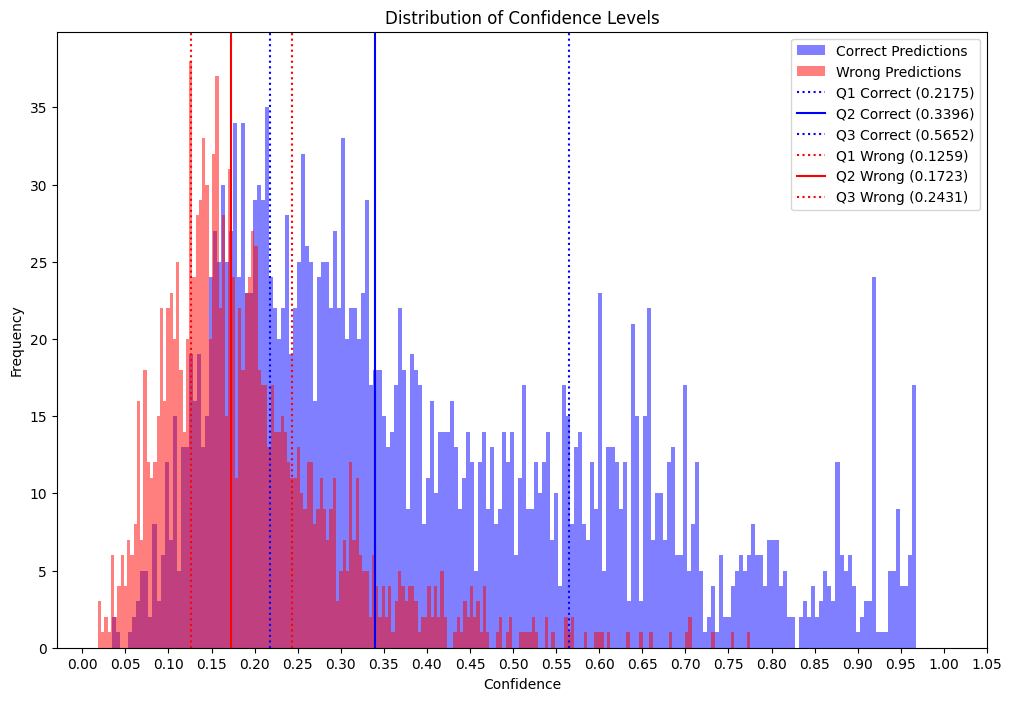

In [ ]:
# confidence_c와 confidence_w의 상위 25%, 50%, 하위 25% 값을 계산
q1_confidence_c = np.percentile(confidence_c, 25)
q2_confidence_c = np.percentile(confidence_c, 50)
q3_confidence_c = np.percentile(confidence_c, 75)
q1_confidence_w = np.percentile(confidence_w, 25)
q2_confidence_w = np.percentile(confidence_w, 50)
q3_confidence_w = np.percentile(confidence_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(confidence_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(confidence_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_confidence_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_confidence_c:.4f})')
plt.axvline(x=q2_confidence_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_confidence_c:.4f})')
plt.axvline(x=q3_confidence_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_confidence_c:.4f})')

plt.axvline(x=q1_confidence_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_confidence_w:.4f})')
plt.axvline(x=q2_confidence_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_confidence_w:.4f})')
plt.axvline(x=q3_confidence_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_confidence_w:.4f})')

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Levels')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 방법 4
# 가능한 임계값 생성
conf_threshold = np.unique(confidence_all)  # confidence_all 에서 중복되지 않는 값들을 임계값으로 설정
best_confidence_f1 = -1
best_confidence_threshold = None

# 모든 임계값에 대해 F1-score 계산
for confidence_threshold in conf_threshold:
    predicted_label = (confidence_all >= confidence_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_confidence_f1:
        best_confidence_f1 = f1
        best_confidence_threshold = confidence_threshold

print("Best Threshold (confidence criterion):", best_confidence_threshold)
print("Best F1-score:", best_confidence_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (confidence_all >= best_confidence_threshold).astype(int)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (confidence criterion): 0.14720727364093775
Best F1-score: 0.8135471086290758
Accuracy: 0.7276
Precision: 0.7265
Recall: 0.9243




---


## **Unmonitored Data 불러오기**

---



In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('/content/gdrive/My Drive/Colab Notebooks/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1.append(time_seq)
    X2.append(size_seq)

print(len(X1)) # Print the length of X1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loading datafile...
Total samples: 10000
10000


## **1. feature 추출**

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df_unmon
df_unmon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec})

In [ ]:
df_unmon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec
0,130,101,29,0.776923,0.223077,17,13,5.56,23.381295
1,9927,9189,738,0.925657,0.074343,18,12,11.88,835.606061
2,359,285,74,0.793872,0.206128,17,13,17.81,20.157215
3,9948,9407,541,0.945617,0.054383,21,9,9.17,1084.841876
4,2508,2215,293,0.883174,0.116826,27,3,53.59,46.799776


In [ ]:
X_test2 = df_unmon
y_pred2 = clf.predict(X_test2)

## **2. Confidence 계산 & -1 label 부여**
> confidence = (1위 class의 확률) * (해당 class의 f1-score)

> confidence가 mon_data의 confidence보다 작을 경우, -1로 분류

> confidence가 mon_data의 confidence보다 클 경우, 0~94 사이 label 부여

In [ ]:
probability = clf.predict_proba(X_test2)
sorted_index = np.argsort(probability, axis=1)
data_list = []
monitored_confidence = []

for i, (sorted_index, pred_class) in enumerate(zip(sorted_index, y_pred2)):
    print(f"Test Data {i + 1}, Predicted Class {pred_class}")
    for j, index in enumerate(sorted_index[::-1][:1]): # 확률 상위 1개 class만 출력
        f1 = f1_class[pred_class]
        pred_proba = probability[i][index]
        confidence = pred_proba * f1
        print(f"Predicted Class {index}: {probability[i][index]}")
        print(f"Class {index}의 f1-score: {f1}")
        print(f"Confidence: {confidence}")
        if(confidence >= best_confidence_threshold) :
          data_list.append([i + 1, pred_class, pred_proba, f1, confidence])
          monitored_confidence.append([pred_class, confidence])
        else : #confidence 가 낮으면 -1로 분류하자
          data_list.append([i + 1, -1, pred_proba, f1, confidence])
          print(f"Confidence < {best_confidence_threshold} --> unmonitored")
    print()

columns = ['Test Data Index', 'Predicted Class', 'Probability', 'f1-score of predicted class','Confidence']
result = pd.DataFrame(data_list, columns=columns)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Test Data 9056, Predicted Class 82
Predicted Class 82: 0.5685457875457876
Class 82의 f1-score: 0.6575342465753423
Confidence: 0.37383832605750406

Test Data 9057, Predicted Class 94
Predicted Class 94: 0.3169383644955544
Class 94의 f1-score: 0.5106382978723404
Confidence: 0.1618408669764533

Test Data 9058, Predicted Class 17
Predicted Class 17: 0.3648323039579308
Class 17의 f1-score: 0.5555555555555556
Confidence: 0.20268461330996157

Test Data 9059, Predicted Class 51
Predicted Class 51: 0.1959345672428564
Class 51의 f1-score: 0.5909090909090908
Confidence: 0.11577951700714241
Confidence < 0.14720727364093775 --> unmonitored

Test Data 9060, Predicted Class 87
Predicted Class 87: 0.2932396647354663
Class 87의 f1-score: 0.6888888888888889
Confidence: 0.20200954681776567

Test Data 9061, Predicted Class 46
Predicted Class 46: 0.4795995266440782
Class 46의 f1-score: 0.5714285714285714
Confidence: 0.27405687236804466

Test Data 9062, Predicted Class 70
Pred

# **3. Show Result**

In [ ]:
result

,Test Data Index,Predicted Class,Probability,f1-score of predicted class,Confidence
0,1,75,0.434834,0.840580,0.365513
1,2,68,0.522521,0.637681,0.333202
2,3,75,0.222793,0.840580,0.187275
3,4,-1,0.165024,0.555556,0.091680
4,5,-1,0.159450,0.630137,0.100475
...,...,...,...,...,...
9995,9996,46,0.758849,0.571429,0.433628
9996,9997,46,0.443121,0.571429,0.253212
9997,9998,75,0.372691,0.840580,0.313276
9998,9999,23,0.219865,0.682353,0.150025


# **4. Binary Classification Result (monitored or unmonitored)**

In [ ]:
# 전체 데이터 수
total_samples = len(result)

# 'Predicted Class'가 -1인 개수 계산
count_minus1 = len(result[result['Predicted Class'] == -1])
print(f'전체 {total_samples}개 중에서 Predicted Class가 -1인 데이터의 개수: {count_minus1}')

# 'Predicted Class'가 0~94인 개수 계산
count_class_monitored = len(result[result['Predicted Class'] != -1])
print(f'전체 {total_samples}개 중에서 Predicted Class가 0~94인 데이터의 개수: {count_class_monitored}')

전체 10000개 중에서 Predicted Class가 -1인 데이터의 개수: 3003
전체 10000개 중에서 Predicted Class가 0~94인 데이터의 개수: 6997


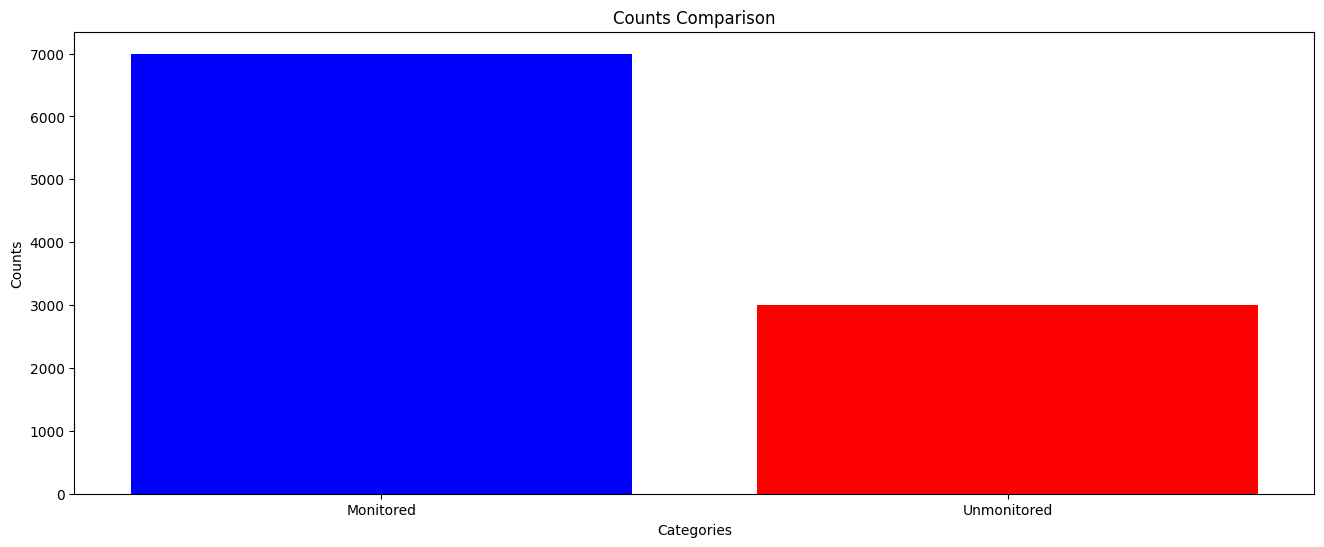

In [ ]:
# 데이터 준비
categories = ['Monitored', 'Unmonitored']
values = [count_class_monitored, count_minus1]

# 그래프 그리기
plt.figure(figsize=(16, 6))

plt.bar(categories, values, color=['blue', 'red'])

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts Comparison')

plt.show()

# **5. Multi-class Classification Result**

In [ ]:
multi_classification_mon = result.loc[result['Predicted Class'] >= 0, ['Test Data Index', 'Predicted Class']]
multi_classification_unmon = result.loc[result['Predicted Class'] == -1, ['Test Data Index', 'Predicted Class']]

In [ ]:
multi_classification_mon  # monitored data로 분류되어 0~94 label 부여받은 dataframe

,Test Data Index,Predicted Class
0,1,75
1,2,68
2,3,75
5,6,31
6,7,44
...,...,...
9995,9996,46
9996,9997,46
9997,9998,75
9998,9999,23


In [ ]:
multi_classification_unmon  # unmonitored data로 분류되어 -1 label 부여받은 dataframe

,Test Data Index,Predicted Class
3,4,-1
4,5,-1
7,8,-1
11,12,-1
13,14,-1
...,...,...
9987,9988,-1
9988,9989,-1
9989,9990,-1
9990,9991,-1


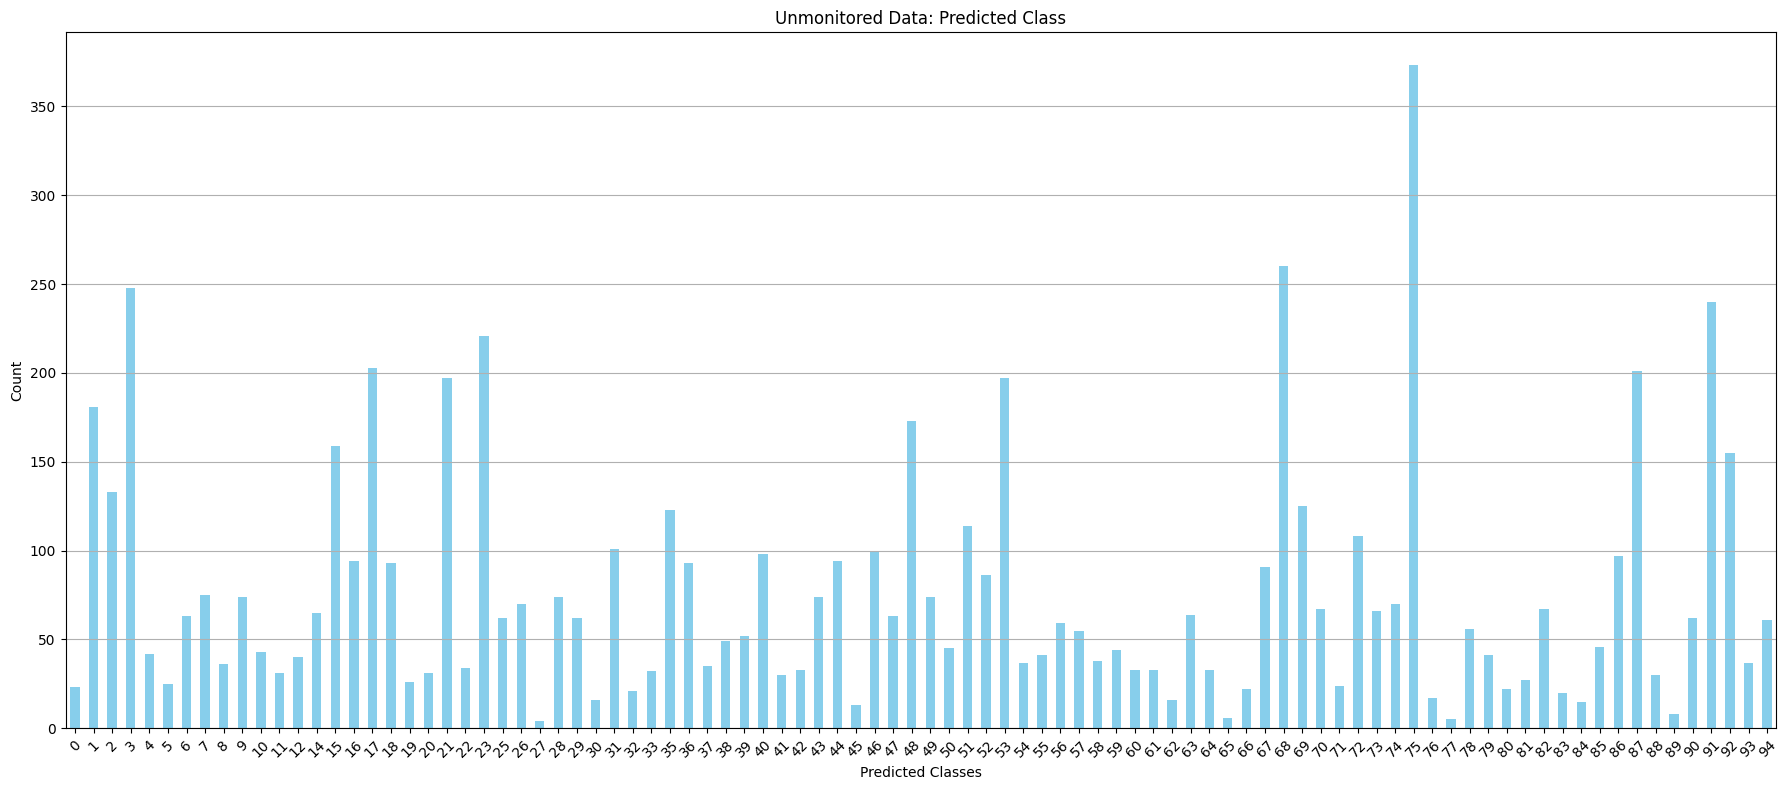

In [ ]:
# 예측된 클래스 별 count 계산
class_counts = multi_classification_mon['Predicted Class'].value_counts().sort_index()

# 클래스 별 count를 시각화하기 위한 그래프 설정
plt.figure(figsize=(18, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Unmonitored Data: Predicted Class')
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 그래프 출력
plt.tight_layout()
plt.show()

In [ ]:
! free -h


               total        used        free      shared  buff/cache   available
Mem:            12Gi        11Gi       234Mi       1.0Mi       707Mi       667Mi
Swap:             0B          0B          0B
